In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
datatrees = ObjIter([Tree(fc.eightb.preselection.JetHT_Data_UL_List)])

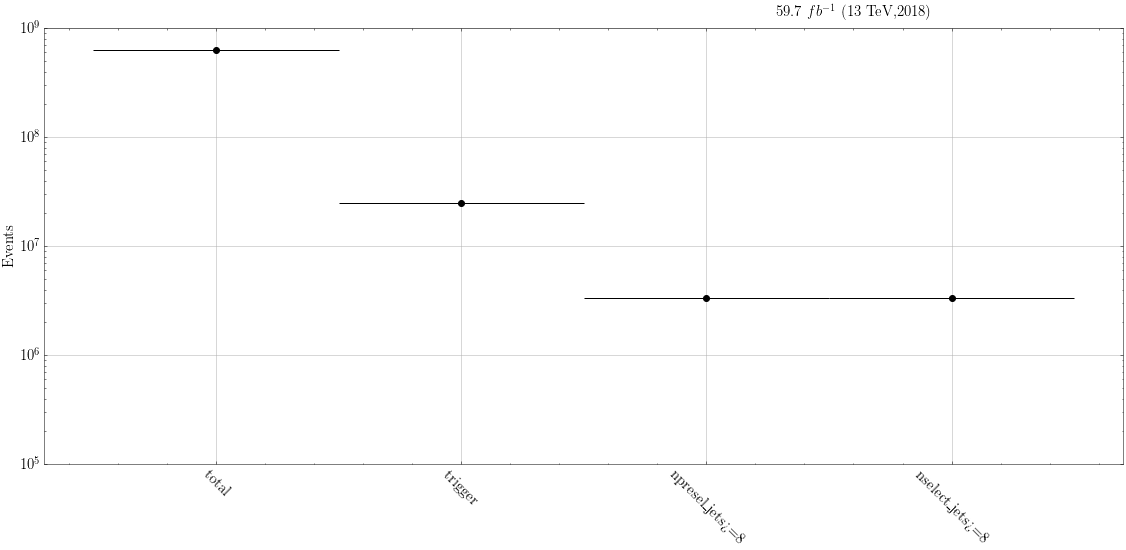

(<Figure size 1152x576 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

In [29]:
study.cutflow(
    datatrees,
    ylim=(1e5,1e9),
    grid=True
)

In [3]:
datatrees.apply(eightb.calc_m_asym)

[None]

In [4]:
datatrees.apply(eightb.set_asym)
datatrees.apply(eightb.hm_asym_diff)


[None]

In [5]:
def count_jets(tree):
    jet_btag = ak.concatenate([ array[:,None] for array in ak.unzip(tree[[f"{bjet}_btag" for bjet in eightb.quarklist]])],axis=-1)
    tree.extend(
        n_loose_btag = ak.sum(jet_btag > jet_btagWP[1],axis=-1),
        n_medium_btag = ak.sum(jet_btag > jet_btagWP[2],axis=-1),
        n_tight_btag = ak.sum(jet_btag > jet_btagWP[3],axis=-1),
    )

In [6]:
datatrees.apply(count_jets)

[None]

In [7]:
region_filters = {
    # 'asrt':FilterSequence(eightb.target_filter, eightb.asr_filter),
    # 'asre':FilterSequence(eightb.estimation_filter, eightb.asr_filter),
    'acrt':FilterSequence(eightb.target_filter, eightb.acr_filter),
    'acre':FilterSequence(eightb.estimation_filter, eightb.acr_filter), 
    'vsrt':FilterSequence(eightb.target_filter, eightb.vsr_filter),
    'vsre':FilterSequence(eightb.estimation_filter, eightb.vsr_filter),
    'vcrt':FilterSequence(eightb.target_filter, eightb.vcr_filter),
    'vcre':FilterSequence(eightb.estimation_filter, eightb.vcr_filter),
}

In [8]:
data_regions = { key: datatrees.apply(filter.filter) for key,filter in region_filters.items() }

In [9]:
data_yields = {}
data_yields['asrt'] = np.array([0])
data_yields['asre'] = np.array([0])
data_yields.update({ key: trees.expected_events().npy for key,trees in data_regions.items() })


In [14]:
data_eff = {}
data_eff['asrt'] = np.array([0])
data_eff['asre'] = np.array([0])
data_eff.update({ key: trees.expected_events().npy/(datatrees.expected_events().npy) for key,trees in data_regions.items() })

In [15]:
def plot_grid(*yields,figax=None, vmax=None,**kwargs):
    if figax is None: figax = plt.subplots()
    fig,ax = figax
    array = np.array([ get_avg_std(nevents) for nevents in yields])
    
    means = array[:,0].reshape(2,2)
    std   = array[:,1].reshape(2,2)
    
    vmin = 0
    if vmax is None: vmax = np.max(means)
    
    im = ax.imshow(means,vmin=vmin,vmax=vmax,cmap='YlOrRd')
    ax.set(yticks=[0,1],yticklabels=['SR','CR'],xticks=[0,1],xticklabels=['TR','ER'],**kwargs)
    for i in range(2):
        for j in range(2):
            txt = f'{means[j,i]:0.3f}'
            if (std[j,i] > 0): txt += f'$\pm${std[j,i]:0.3f}'
            ax.text(i,j,f'{txt}',ha="center", va="center", fontweight="bold")
    

In [20]:
ar_keys = ['asrt','asre','acrt','acre']
vr_keys = ['vsrt','vsre','vcrt','vcre']


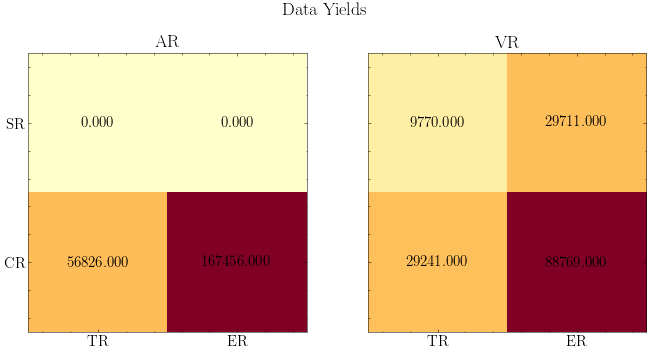

In [21]:
fig,axs = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
plot_grid(*[ data_yields[key] for key in ar_keys ], figax=(fig,axs[0]), title='AR')
plot_grid(*[ data_yields[key] for key in vr_keys ], figax=(fig,axs[1]), title='VR')
fig.suptitle('Data Yields')
fig.tight_layout()

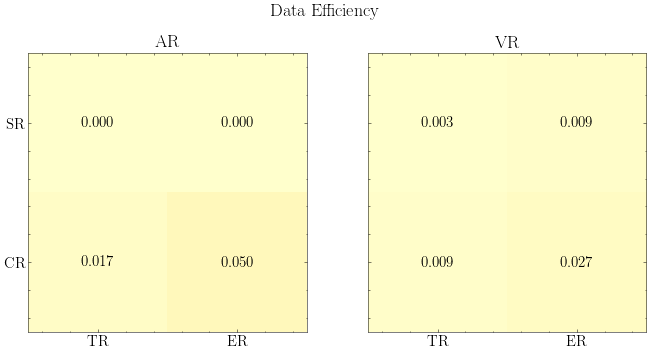

In [22]:
fig,axs = plt.subplots(ncols=2,figsize=(10,5),sharey=True)
plot_grid(*[ data_eff[key] for key in ar_keys ], figax=(fig,axs[0]), title='AR', vmax=1)
plot_grid(*[ data_eff[key] for key in vr_keys ], figax=(fig,axs[1]), title='VR', vmax=1)
fig.suptitle('Data Efficiency')
fig.tight_layout()